In [333]:
import random
import time

import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [12]:
# Are not running on a GPU, but have GPU support
print(tf.test.gpu_device_name())
print(tf.test.is_built_with_gpu_support())
print(tf.test.is_built_with_cuda())


True
True


In [15]:
random_seed = 1
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [3]:
df = pd.read_csv('https://storage.googleapis.com/goodwatercap_fs/public/ml_take_home_data/ml_take_home_data_sample.csv')
print(df.shape)
df.head()

(100000, 9)


,date,year,month,day_of_week,rank,rank_last_month,downloads,downloads_last_month,downloads_next_month
0,2013-02-03,2013,2,1,10540,6835,1240,1728,1495
1,2013-02-03,2013,2,1,33884,34071,200,177,158
2,2013-02-03,2013,2,1,2194,2030,6225,5757,1849
3,2013-02-03,2013,2,1,40288,40543,107,95,32
4,2013-02-03,2013,2,1,28329,32121,291,203,374


In [331]:
df_full = pd.read_csv('https://storage.googleapis.com/goodwatercap_fs/public/ml_take_home_data/ml_take_home_data_full.csv')
print(df_full.shape)
df_full.head()

(10000000, 9)


,date,year,month,day_of_week,rank,rank_last_month,downloads,downloads_last_month,downloads_next_month
0,2019-01-09,2019,1,4,26422,29816,751,555,397
1,2014-01-01,2014,1,4,46364,46168,19,17,19
2,2019-01-01,2019,1,3,2941,2869,10754,11935,5230
3,2019-01-22,2019,1,3,33063,32831,466,521,441
4,2018-01-17,2018,1,4,52752,53281,51,48,45


# Neural Network Model

In [4]:
# Select features to be used
reg_features = ['downloads', 'downloads_last_month', 'rank', 'rank_last_month', 'year', 'month', 'day_of_week']
y_var = 'downloads_next_month'
X = np.log10(df[reg_features].copy())
y = np.log10(df[y_var].copy())

In [36]:
print(X.iloc[0].shape)

(7,)


In [5]:
# Split between train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [6]:
# Normalize the features
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
# Define the hidden layer dimensions
layers_dimensions = (100, 50, 20, 5)

In [208]:
%%time
model = MLPRegressor(hidden_layer_sizes = layers_dimensions, random_state=random_seed)
model.fit(X_train, y_train)

CPU times: user 1min 1s, sys: 1.61 s, total: 1min 2s
Wall time: 10.5 s


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100, 50, 20, 5), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=1, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [205]:
%%time
predict_train_baseline = model.predict(X_train)
predict_test_baseline = model.predict(X_test)

rmse_train_baseline = np.sqrt(mean_squared_error(y_train, predict_train_baseline))
rmse_test_baseline = np.sqrt(mean_squared_error(y_test, predict_test_baseline))

r2_train_baseline = r2_score(y_train, predict_train_baseline)
r2_test_baseline = r2_score(y_test, predict_test_baseline)

print('RMSE train was %.5f' % rmse_train_baseline)
print('RMSE test was %.5f' % rmse_test_baseline)
print('R2 train was %.5f' % r2_train_baseline)
print('R2 test was %.5f' % r2_test_baseline)

RMSE train was 0.21554
RMSE test was 0.21307
R2 train was 0.91532
R2 test was 0.91754
CPU times: user 1.91 s, sys: 2.29 s, total: 4.2 s
Wall time: 1.19 s


# Optimized Neural Network Model

Baseline CPU time is about 60 seconds. How can this be improved?

Adam optimizer is already being used, and it's typically the fastest optimizer. So keep that the same.

Add early_stopping - stop before based on validation loss rather than training loss - decreases training time to 50 seconds

In [276]:
%%time
model = MLPRegressor(hidden_layer_sizes = layers_dimensions, random_state=1, early_stopping=True)
model.fit(X_train, y_train)

CPU times: user 43.7 s, sys: 880 ms, total: 44.6 s
Wall time: 7.48 s


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=True, epsilon=1e-08,
             hidden_layer_sizes=(100, 50, 20, 5), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=1, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [277]:
%%time
predict_train = model.predict(X_train)
predict_test = model.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, predict_train))
rmse_test = np.sqrt(mean_squared_error(y_test, predict_test))

r2_train = r2_score(y_train, predict_train)
r2_test = r2_score(y_test, predict_test)

print('RMSE train', rmse_train, 'difference from baseline', rmse_train - rmse_train_baseline)
print('RMSE test', rmse_test, 'difference from baseline', rmse_test - rmse_test_baseline)
print('R2 train', r2_train, 'difference from baseline', r2_train - r2_train_baseline)
print('R2 test', r2_test, 'difference from baseline', r2_test - r2_test_baseline)

RMSE train 0.21693550096467135 difference from baseline 0.0013941990319328579
RMSE test 0.2139183885844201 difference from baseline 0.0008506874077058302
R2 train 0.9142206250020465 difference from baseline -0.0010990291565324828
R2 test 0.9168784909799671 difference from baseline -0.000659782683850918
CPU times: user 1.46 s, sys: 1.25 s, total: 2.71 s
Wall time: 550 ms


In [299]:
# Overall the prediction distributions are similar
pred_mod_df = pd.DataFrame(predict_test, columns=['prediction_mod'], index=y_test.index)
pred_baseline_df = pd.DataFrame(predict_test_baseline, columns=['prediction_baseline'], index=y_test.index)
all_preds = pd.concat([pred_mod_df, pred_baseline_df, y_test], axis=1)
all_preds['diff'] = all_preds['prediction_mod'] - all_preds['prediction_baseline']
all_preds

,prediction_mod,prediction_baseline,downloads_next_month,diff
43660,3.497298,3.566452,3.543074,-0.069154
87278,2.785889,2.807038,2.667453,-0.021149
14317,2.175071,2.135610,2.257679,0.039461
81932,2.360877,2.381606,2.480007,-0.020729
95321,2.473328,2.473618,2.184691,-0.000290
...,...,...,...,...
73441,1.223454,1.131422,1.518514,0.092033
1341,2.832989,2.854579,2.740363,-0.021590
71987,2.282947,2.278812,2.262451,0.004135
26910,2.554724,2.505752,2.751279,0.048971


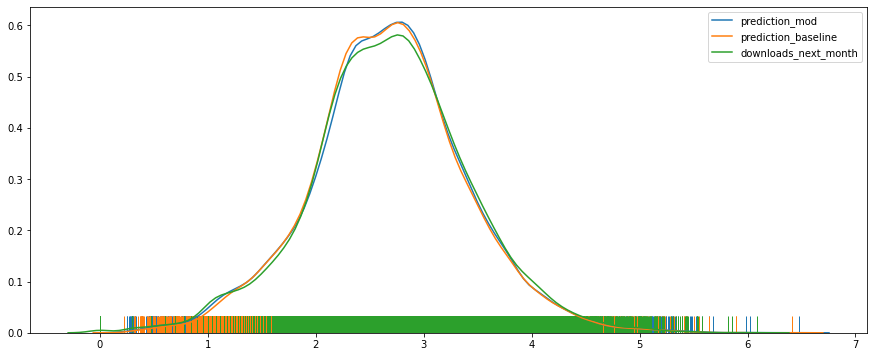

In [315]:
import seaborn as sns

f, ax = plt.subplots(figsize=(15, 6))

for col in ['prediction_mod', 'prediction_baseline', 'downloads_next_month']:
    sns.distplot(all_preds[[col]], label=col, hist=False, rug=True, ax=ax)

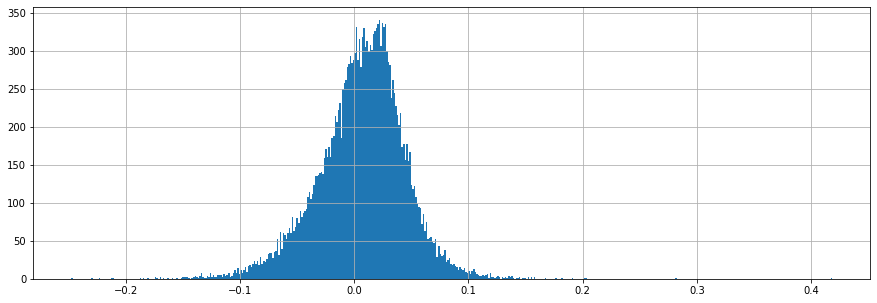

In [313]:
all_preds['diff'].hist(figsize=(15, 5), bins=500)

scikit-learn does not have GPU support: https://scikit-learn.org/stable/faq.html#will-you-add-gpu-support, which is needed for faster deep learning model training. So let's port this network architecture to Keras. On a GPU, this will speed up training. 

In [235]:
def basic_model_with_regularization(input_shape, layers_dimensions, should_add_dropout=False):
    """
    Add batch normalization and appropriate weight initialization.
    """
    kernel_initializer = 'he_uniform'
    input_layer = Input(shape=input_shape)
    current_layer = input_layer
    for layer_dimension in layers_dimensions:
        layer = Dense(layer_dimension, activation='relu',
                      kernel_initializer=kernel_initializer, use_bias=False)(current_layer)
        current_layer = BatchNormalization()(layer)

    if should_add_dropout:
        current_layer = Dropout(.2)(current_layer)
    
    output = Dense(1, kernel_initializer=kernel_initializer, activation='linear')(current_layer)

    return Model(inputs=input_layer, outputs=output)

def basic_model_with_regularization(input_shape, layers_dimensions, should_add_dropout=False):
    """
    Add batch normalization and appropriate weight initialization.
    """
    activity_regularizer = tf.keras.regularizers.l2(l=1e-4)
    kernel_initializer = 'he_uniform'
    input_layer = Input(shape=input_shape)
    current_layer = input_layer
    for layer_dimension in layers_dimensions:
        current_layer = Dense(layer_dimension, activation='relu',
                              kernel_initializer=kernel_initializer, 
                              activity_regularizer=activity_regularizer)(current_layer)

    if should_add_dropout:
        current_layer = Dropout(.2)(current_layer)
    
    output = Dense(1, kernel_initializer=kernel_initializer, 
                   activity_regularizer=activity_regularizer, 
                   activation='linear')(current_layer)

    return Model(inputs=input_layer, outputs=output)

In [251]:
model = basic_model_with_regularization(input_shape=(7,), layers_dimensions=[100, 50, 20, 5])

In [184]:
# sanity check model output
model.summary()

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 7)]               0         
_________________________________________________________________
dense_64 (Dense)             (None, 100)               700       
_________________________________________________________________
dense_65 (Dense)             (None, 50)                5000      
_________________________________________________________________
dense_66 (Dense)             (None, 20)                1000      
_________________________________________________________________
dense_67 (Dense)             (None, 5)                 100       
_________________________________________________________________
dense_68 (Dense)             (None, 1)                 6         
Total params: 6,806
Trainable params: 6,806
Non-trainable params: 0
________________________________________________________

In [142]:
def get_dataset(x, y, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    return dataset.prefetch(100).batch(batch_size).shuffle(buffer_size=len(x))

def get_predictor_dataset(x, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((x))
    return dataset.prefetch(100).batch(batch_size).shuffle(buffer_size=len(x))

In [212]:
X_train_subset, X_valid, y_train_subset, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=random_seed)

train_generator = get_dataset(X_train_subset, y_train_subset, 200)
validation_generator = get_dataset(X_valid, y_valid, 200)

In [325]:
%%time
model = basic_model_with_regularization(input_shape=(7,), layers_dimensions=[100, 50, 20, 5])
metric_to_monitor = 'val_loss'
loss = 'mean_squared_error'
early_stopping_patience = 5
tolerance = 1e-3
callbacks = [
    EarlyStopping(monitor=metric_to_monitor, mode='min', min_delta=tolerance, 
                  patience=early_stopping_patience, verbose=verbosity, restore_best_weights=True),
]
lr = 1e-3
optimizer = Adam(learning_rate=lr, epsilon=1e-8)
n_epochs = 100
model.compile(loss=loss, optimizer=optimizer)
history = model.fit(x=X_train_subset, y=y_train_subset.values, validation_data=(X_valid, y_valid.values), 
                    epochs=n_epochs, batch_size=256,
                    callbacks=callbacks, max_queue_size=len(X_train_subset))

Train on 72000 samples, validate on 8000 samples
Epoch 1/100
72000/72000 [==============================] - 2s 32us/sample - loss: 0.4880 - val_loss: 0.0855
Epoch 2/100
72000/72000 [==============================] - 1s 16us/sample - loss: 0.0792 - val_loss: 0.0767
Epoch 3/100
72000/72000 [==============================] - 1s 13us/sample - loss: 0.0740 - val_loss: 0.0723
Epoch 4/100
72000/72000 [==============================] - 1s 13us/sample - loss: 0.0709 - val_loss: 0.0700
Epoch 5/100
72000/72000 [==============================] - 1s 13us/sample - loss: 0.0686 - val_loss: 0.0692
Epoch 6/100
72000/72000 [==============================] - 1s 13us/sample - loss: 0.0670 - val_loss: 0.0682
Epoch 7/100
72000/72000 [==============================] - 1s 14us/sample - loss: 0.0655 - val_loss: 0.0651
Epoch 8/100
72000/72000 [==============================] - 1s 14us/sample - loss: 0.0644 - val_loss: 0.0637
Epoch 9/100
72000/72000 [==============================] - 1s 14us/sample - loss: 0.063

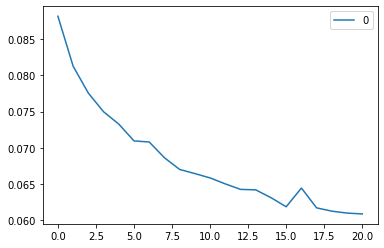

In [319]:
pd.DataFrame(history.history['val_loss'][1:]).plot()

In [326]:
%%time
predict_train = model.predict(get_predictor_dataset(X_train, 128))
predict_test = model.predict(get_predictor_dataset(X_test, 128))

rmse_train = np.sqrt(mean_squared_error(y_train, predict_train))
rmse_test = np.sqrt(mean_squared_error(y_test, predict_test))

r2_train = r2_score(y_train, predict_train)
r2_test = r2_score(y_test, predict_test)

print('\n')
print('RMSE train', rmse_train, '% difference from baseline', (rmse_train / rmse_train_baseline - 1) * 100)
print('RMSE test', rmse_test, '% difference from baseline', (rmse_test / rmse_test_baseline - 1) * 100)
print('R2 train', r2_train, '% difference from baseline', (r2_train / r2_train_baseline - 1) * 100)
print('R2 test', r2_test, '% difference from baseline', (r2_test / r2_test_baseline - 1) * 100)



RMSE train 0.21464677807398344 % difference from baseline -0.4150127380385782
RMSE test 0.21284251672636895 % difference from baseline -0.10568680710483225
R2 train 0.9160210641055064 % difference from baseline 0.07663005418279134
R2 test 0.9177124838878301 % difference from baseline 0.0189866983222986
CPU times: user 1.12 s, sys: 840 ms, total: 1.96 s
Wall time: 1.43 s


In [327]:
pred_mod_df = pd.DataFrame(predict_test, columns=['prediction_mod'], index=y_test.index)
pred_baseline_df = pd.DataFrame(predict_test_baseline, columns=['prediction_baseline'], index=y_test.index)
all_preds = pd.concat([pred_mod_df, pred_baseline_df, y_test], axis=1)
all_preds['diff'] = all_preds['prediction_mod'] - all_preds['prediction_baseline']
all_preds.sort_values(by='diff')

,prediction_mod,prediction_baseline,downloads_next_month,diff
6709,2.010658,2.388369,2.117271,-0.377711
19835,1.140396,1.495887,0.903090,-0.355491
57410,5.045264,5.388202,5.433298,-0.342938
83140,2.740880,3.071218,2.996074,-0.330339
13514,1.253800,1.583183,1.361728,-0.329383
...,...,...,...,...
29466,1.320051,1.102504,1.176091,0.217547
46862,1.348328,1.128964,1.146128,0.219363
22151,0.602141,0.371406,0.301030,0.230735
17423,3.006428,2.770079,2.947434,0.236350


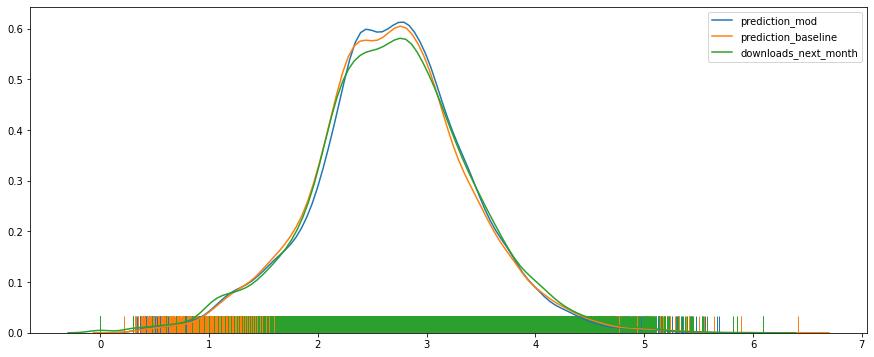

In [328]:
f, ax = plt.subplots(figsize=(15, 6))

for col in ['prediction_mod', 'prediction_baseline', 'downloads_next_month']:
    sns.distplot(all_preds[[col]], label=col, hist=False, rug=True, ax=ax)

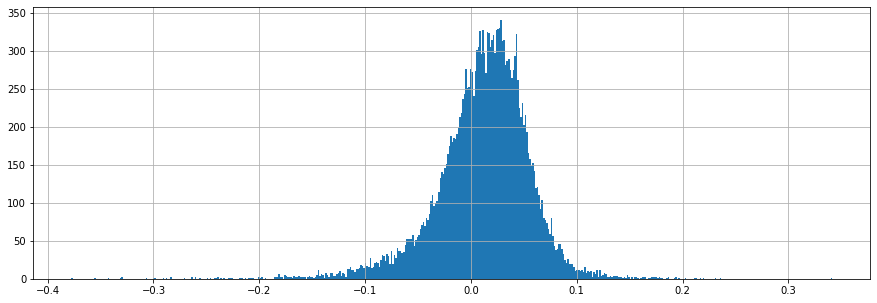

In [329]:
all_preds['diff'].hist(figsize=(15, 5), bins=500)

In [ ]:
# pretty low difference in precision between the float64 and float32 dtypes
((X - X.astype(np.float16)) / X).abs().max()

In [ ]:
# history = model.fit_generator(generator=train_generator, validation_data=validation_generator, epochs=n_epochs, 
#                     callbacks=callbacks, max_queue_size=len(X_train_subset))